# 02 - Expression QC and PCA

Load the processed TPM matrix, perform basic quality-checks, and derive PCA embeddings for downstream visualization or clustering notebooks.


## PC1 v/s PC2 across biospecimen continuous metrics
### 1. Days to collection (processing latency)
### 2. RNA concentration (ng/\u03bcL)
### 3. Aliquot quantity (mg)


In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context("talk")


def find_project_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "README.md").exists():
            return candidate
    raise FileNotFoundError("Unable to locate repository root (README.md not found)")


PROJECT_ROOT = find_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.config import ProjectConfig
from src.data_loading import load_expression_manifest, load_expression_tpm
from src.plotting import plot_pca_categorical,plot_pca_continuous

config = ProjectConfig()
PROCESSED_DATA_DIR = config.processed_data_dir
EXPRESSION_PATH = PROCESSED_DATA_DIR / "tcga_brca_expression_tpm.tsv.gz"
EXPRESSION_PATH

PosixPath('/Users/lennonmccartney/Desktop/tcga-brca-multiomics-subtyping/data/processed/tcga_brca_expression_tpm.tsv.gz')

In [2]:
expression_df = load_expression_tpm()
expression_df.shape

(60660, 1197)

In [3]:
expression_index_with_biospecimen = load_expression_manifest()
expression_index_with_biospecimen.head()

,file_name,bundle_id,relative_path,entity_submitter_id,entity_type,case_id,entity_id,access,submitter_id,data_category,...,experimental_protocol_type,normal_tumor_genotype_snp_match,aliquot_id,aliquot_quantity,aliquot_volume,concentration,source_center,center,state,file_size_mb
0,ba295155-272e-43eb-9d6a-e4c9c392e68b.rna_seq.a...,0019c951-16c5-48d0-85c8-58d96b12d330,0019c951-16c5-48d0-85c8-58d96b12d330/ba295155-...,TCGA-D8-A1XO-01A-11R-A14M-07,aliquot,6a186809-3422-41d0-83d2-867145830936,eddd285e-a946-4e4e-a21d-6e84ed397594,controlled,0e68b49d-a54d-41c3-a5f7-13fc141ab0e8,Sequencing Reads,...,mirVana (Allprep DNA) RNA,Yes,eddd285e-a946-4e4e-a21d-6e84ed397594,4.27,26.7,0.16,23,"{'code': '07', 'center_id': 'ee7a85b3-8177-5d6...",released,4.055
1,8d1641ea-7552-4d23-9298-094e0056386a.rna_seq.a...,0022cd20-f64f-4773-b9ff-a3de0b71b259,0022cd20-f64f-4773-b9ff-a3de0b71b259/8d1641ea-...,TCGA-AN-A0FN-01A-11R-A034-07,aliquot,c2a742fe-3e8b-4210-85a6-7191a1123609,4aac7c40-db6b-4648-a82a-7bf397de913a,controlled,fd4c1bc5-6eab-4830-9178-afbab6a7a954,Sequencing Reads,...,mirVana (Allprep DNA) RNA,Yes,4aac7c40-db6b-4648-a82a-7bf397de913a,4.27,26.7,0.16,23,"{'code': '07', 'center_id': 'ee7a85b3-8177-5d6...",released,4.052
2,2f51534b-248b-4999-bc3f-e42a2e98332e.rna_seq.a...,00469928-b243-4cae-acd7-134508e99ceb,00469928-b243-4cae-acd7-134508e99ceb/2f51534b-...,TCGA-AC-A62X-01A-11R-A29R-07,aliquot,5b2a4f11-ca46-4974-9420-59b4820920bf,cdc523d2-da82-4a3d-a97e-9745c8a802d1,controlled,6920521e-f04a-4ae1-b161-df65804500b6,Sequencing Reads,...,mirVana (Allprep DNA) RNA,Yes,cdc523d2-da82-4a3d-a97e-9745c8a802d1,1.95,13.0,0.15,23,"{'code': '07', 'center_id': 'ee7a85b3-8177-5d6...",released,4.037
3,b321a3f5-043d-42c6-8c9d-5784d45cb85c.rna_seq.a...,0081f507-b104-4214-9ea1-31dd69130991,0081f507-b104-4214-9ea1-31dd69130991/b321a3f5-...,TCGA-E2-A14U-01A-11R-A22K-07,aliquot,23b7aaea-1119-4b10-aa1a-0ae255d2f2a6,20d25e27-b509-45eb-a734-9b8d6a40c632,controlled,f8ed6c74-0202-4ac0-a581-b00c504e9e4b,Sequencing Reads,...,mirVana (Allprep DNA) RNA,Yes,20d25e27-b509-45eb-a734-9b8d6a40c632,2.08,13.0,0.16,23,"{'code': '07', 'center_id': 'ee7a85b3-8177-5d6...",released,4.058
4,cafc9e36-c5f0-45df-ad03-16210ff0d870.rna_seq.a...,0094f9d0-45ec-4aad-bca0-71c60bdd7113,0094f9d0-45ec-4aad-bca0-71c60bdd7113/cafc9e36-...,TCGA-E9-A1R3-01A-31R-A14M-07,aliquot,4922cddc-575c-4b8a-8245-ce5f6876760c,678ba111-3b01-49b7-83d9-165ef0288a34,controlled,71af5a94-601d-4710-834a-ee8ac0265d20,Sequencing Reads,...,mirVana (Allprep DNA) RNA,Yes,678ba111-3b01-49b7-83d9-165ef0288a34,4.27,26.7,0.16,23,"{'code': '07', 'center_id': 'ee7a85b3-8177-5d6...",released,4.059


In [4]:
expression_index_with_biospecimen.columns

Index(['file_name', 'bundle_id', 'relative_path', 'entity_submitter_id',
       'entity_type', 'case_id', 'entity_id', 'access', 'submitter_id',
       'data_category', 'file_id', 'data_type', 'experimental_strategy',
       'case_id_biospecimen', 'case_submitter_id', 'project_id',
       'submitter_id_biospecimen', 'sample_id', 'sample_type', 'specimen_type',
       'tumor_descriptor', 'preservation_method', 'tissue_type',
       'days_to_collection', 'portion_id', 'analyte_id', 'analyte_type',
       'experimental_protocol_type', 'normal_tumor_genotype_snp_match',
       'aliquot_id', 'aliquot_quantity', 'aliquot_volume', 'concentration',
       'source_center', 'center', 'state', 'file_size_mb'],
      dtype='object')

## Basic QC summaries

Capture simple dataset-level stats (samples, genes, sequencing depth proxies) to confirm nothing exploded during preprocessing.


In [5]:
n_genes, n_samples = expression_df.shape
sample_totals = expression_df.sum(axis=0)

summary = pd.Series(
    {
        "n_genes": n_genes,
        "n_samples": n_samples,
        "median_sample_depth": float(sample_totals.median()),
        "min_sample_depth": float(sample_totals.min()),
        "max_sample_depth": float(sample_totals.max()),
    }
)
summary

n_genes                    60660.0
n_samples                   1197.0
median_sample_depth     57331767.0
min_sample_depth        19225117.0
max_sample_depth       114015705.0
dtype: float64

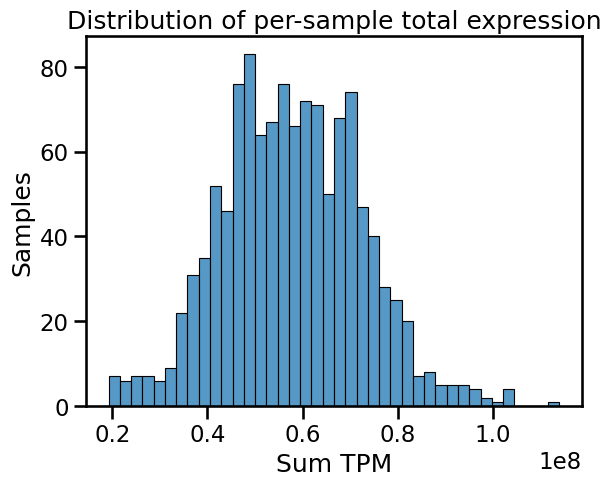

In [6]:
ax = sns.histplot(sample_totals, bins=40)
ax.set_title("Distribution of per-sample total expression")
ax.set_xlabel("Sum TPM")
_ = ax.set_ylabel("Samples")

## Preprocess matrix for PCA

Use the shared preprocessing helpers (mean filter, log transform, z-score scaling) to stabilize the expression values.


In [7]:
from src.preprocessing import filter_low_expression, log_transform, scale_features

filtered_df = filter_low_expression(expression_df, min_mean=1.0)
log_df = log_transform(filtered_df, pseudo_count=1.0)
scaled_df = scale_features(log_df)
filtered_df.shape, scaled_df.shape

((35790, 1197), (35790, 1197))

## Principal component analysis

Run PCA on the scaled expression matrix (samples as rows). Keep 50 components for downstream manifold learning.


In [8]:
from src.dimensionality_reduction import run_pca

n_components = 50
pca_df, pca_model = run_pca(scaled_df, n_components=n_components, return_model=True)
explained_variance = pd.Series(pca_model.explained_variance_ratio_, index=pca_df.columns)
pca_df.head()

/Users/lennonmccartney/Desktop/tcga-brca-multiomics-subtyping/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
eddd285e-a946-4e4e-a21d-6e84ed397594,66.881381,10.464202,-17.882775,24.450980,-34.534961,12.962275,-5.833964,27.902865,25.287797,-1.656168,...,4.840135,-9.810804,5.326876,-1.743993,10.895772,-1.771303,2.014357,-0.877309,0.184497,-3.534204
4aac7c40-db6b-4648-a82a-7bf397de913a,32.429013,-9.957598,40.264804,42.590246,-21.292736,55.190396,-33.987849,3.572891,0.974376,20.818672,...,-1.828826,-6.862730,4.830118,-9.513705,6.407914,-6.499774,-4.540029,-2.748677,-3.104844,1.421216
cdc523d2-da82-4a3d-a97e-9745c8a802d1,-87.738503,39.949205,46.913361,-59.784433,6.412864,-62.221974,-7.556203,22.414156,21.887043,-7.342581,...,7.690612,-6.034682,-29.825285,-0.573876,24.762176,-20.917960,-2.107538,3.631840,-2.675258,8.189914
20d25e27-b509-45eb-a734-9b8d6a40c632,58.511724,9.020735,-12.361333,47.892200,76.432903,-41.735964,17.798618,19.477678,13.830445,-26.064546,...,15.193230,3.339026,4.397652,-0.649963,0.078738,8.589395,5.984064,2.373127,4.694300,-4.044868
678ba111-3b01-49b7-83d9-165ef0288a34,91.537910,34.798539,-5.758935,18.729015,-18.983191,20.311883,-31.539405,23.071203,5.154782,2.454015,...,13.733020,-3.224252,9.158292,-0.976767,1.603692,-1.013049,-11.823112,-5.078651,10.120465,-7.915902


In [9]:
biospecimen_fields = [
    "sample_type",
    "tumor_descriptor",
    "specimen_type",
    "preservation_method",
    "tissue_type",
    "days_to_collection",
    "analyte_type",
    "aliquot_quantity",
    "aliquot_volume",
    "concentration",
    "normal_tumor_genotype_snp_match",
    "source_center"
]

if "entity_id" not in expression_index_with_biospecimen.columns:
    raise KeyError("expression_index_with_biospecimen must contain an 'entity_id' column for joins")
lookup = (
    expression_index_with_biospecimen.drop_duplicates(subset=["entity_id"])
    .set_index("entity_id")
    .copy()
)
missing_fields = [col for col in biospecimen_fields if col not in lookup.columns]
for col in missing_fields:
    lookup[col] = pd.NA
pca_with_biospecimen = pca_df.join(lookup[biospecimen_fields], how="left")
if missing_fields:
    print(f"Missing biospecimen fields in manifest: {', '.join(missing_fields)}")
pca_with_biospecimen.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,specimen_type,preservation_method,tissue_type,days_to_collection,analyte_type,aliquot_quantity,aliquot_volume,concentration,normal_tumor_genotype_snp_match,source_center
eddd285e-a946-4e4e-a21d-6e84ed397594,66.881381,10.464202,-17.882775,24.450980,-34.534961,12.962275,-5.833964,27.902865,25.287797,-1.656168,...,Solid Tissue,Unknown,Tumor,193.0,RNA,4.27,26.7,0.16,Yes,23
4aac7c40-db6b-4648-a82a-7bf397de913a,32.429013,-9.957598,40.264804,42.590246,-21.292736,55.190396,-33.987849,3.572891,0.974376,20.818672,...,Solid Tissue,Unknown,Tumor,57.0,RNA,4.27,26.7,0.16,Yes,23
cdc523d2-da82-4a3d-a97e-9745c8a802d1,-87.738503,39.949205,46.913361,-59.784433,6.412864,-62.221974,-7.556203,22.414156,21.887043,-7.342581,...,Solid Tissue,Unknown,Tumor,70.0,RNA,1.95,13.0,0.15,Yes,23
20d25e27-b509-45eb-a734-9b8d6a40c632,58.511724,9.020735,-12.361333,47.892200,76.432903,-41.735964,17.798618,19.477678,13.830445,-26.064546,...,Solid Tissue,Unknown,Tumor,796.0,RNA,2.08,13.0,0.16,Yes,23
678ba111-3b01-49b7-83d9-165ef0288a34,91.537910,34.798539,-5.758935,18.729015,-18.983191,20.311883,-31.539405,23.071203,5.154782,2.454015,...,Solid Tissue,OCT,Tumor,80.0,RNA,4.27,26.7,0.16,Yes,23


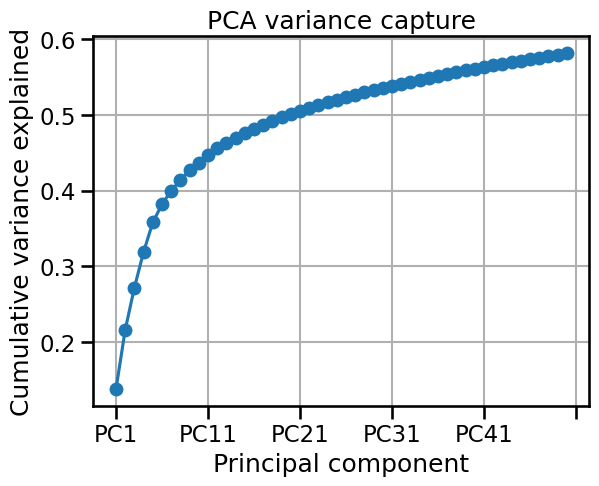

In [10]:
ax = explained_variance.cumsum().plot(marker='o')
ax.set_ylabel('Cumulative variance explained')
ax.set_xlabel('Principal component')
ax.set_title('PCA variance capture')
ax.grid(True)

## PC1 v/s PC2 across the below categorical variables
### 1. Sample Types: Primary Tumors, Solid Tissue, Metastatic
### 2. Preservation Method: FFPE v/s OCT
### 3. Tumor Descriptor: Primary v/s Metastatic                                                                                                                   

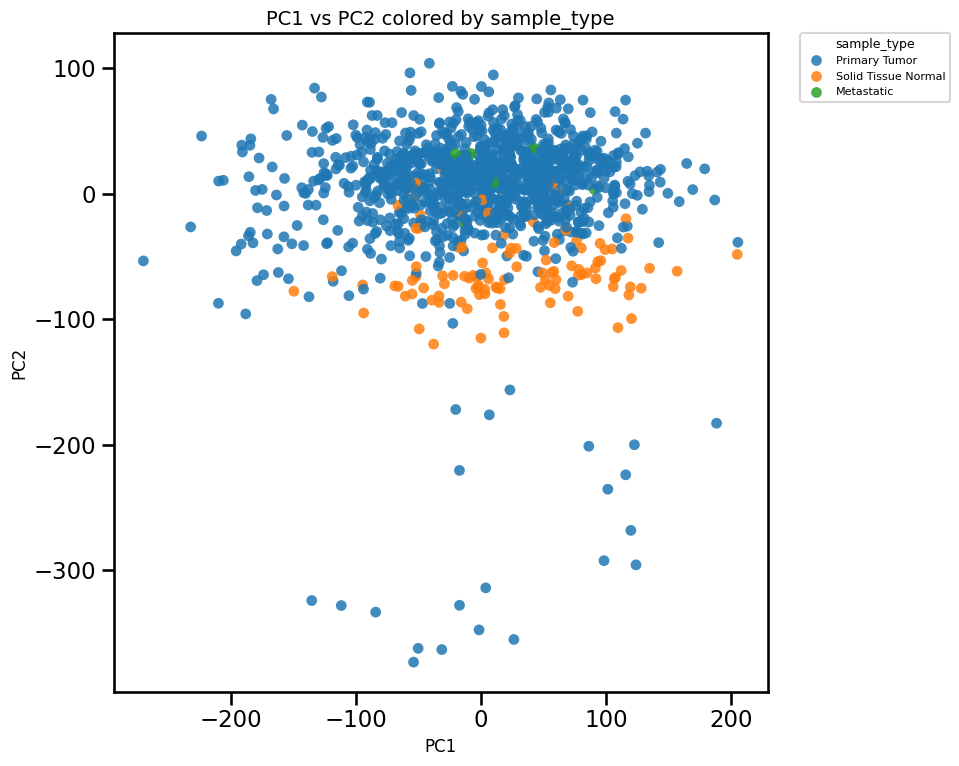

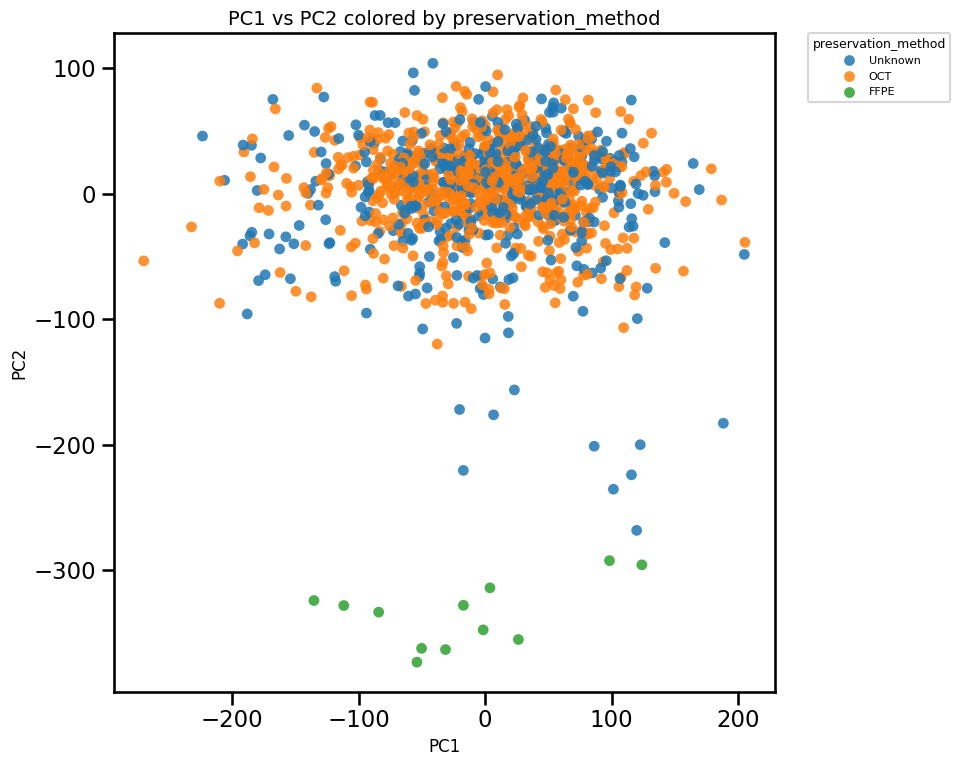

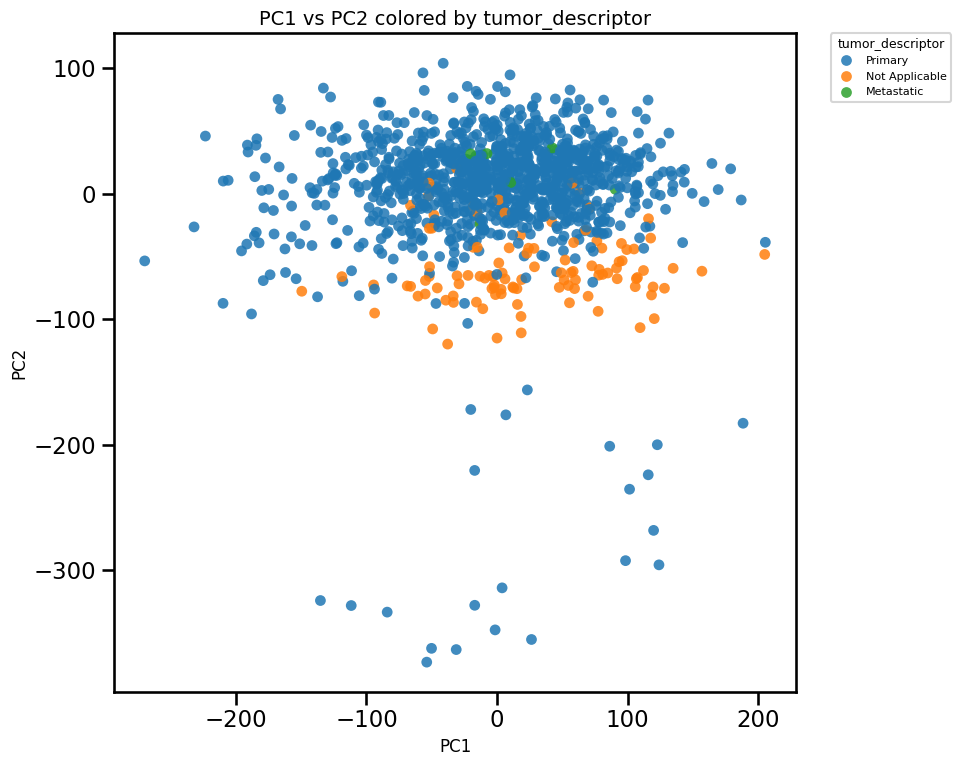

In [11]:
plot_pca_categorical(pca_with_biospecimen, hue_col="sample_type")
plot_pca_categorical(pca_with_biospecimen, hue_col="preservation_method")
plot_pca_categorical(pca_with_biospecimen, hue_col="tumor_descriptor")

## PC2 v/s PC3 across the below categorical variables
### 1. Sample Types: Primary Tumors, Solid Tissue, Metastatic
### 2. Preservation Method: FFPE v/s OCT
### 3. Tumor Descriptor: Primary v/s Metastatic                                                                                                                   

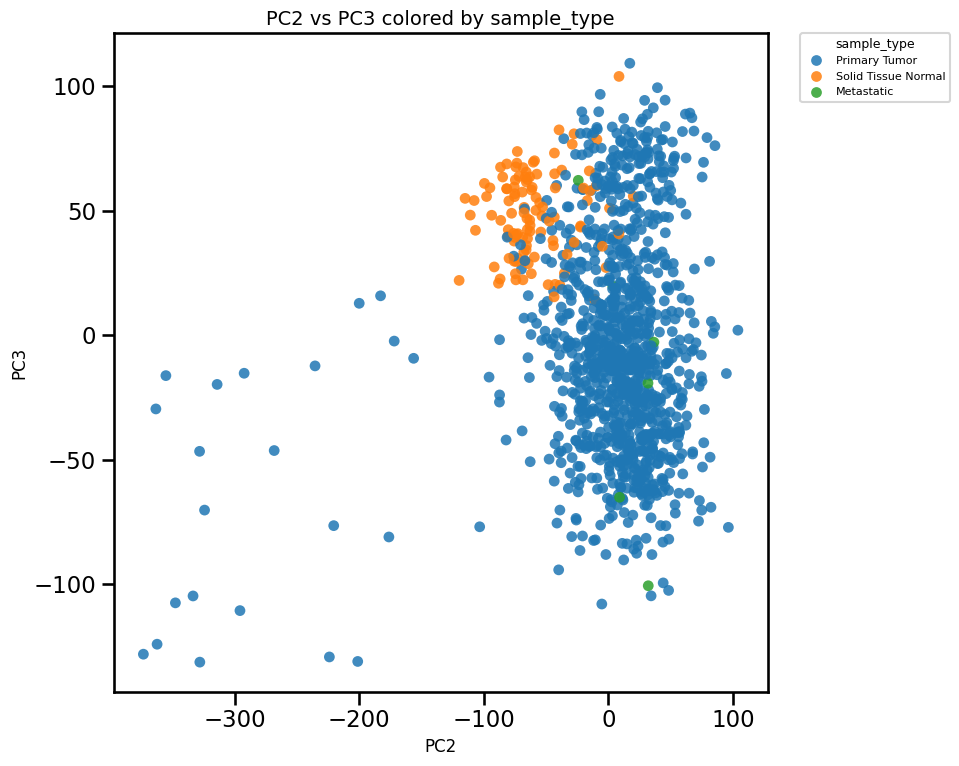

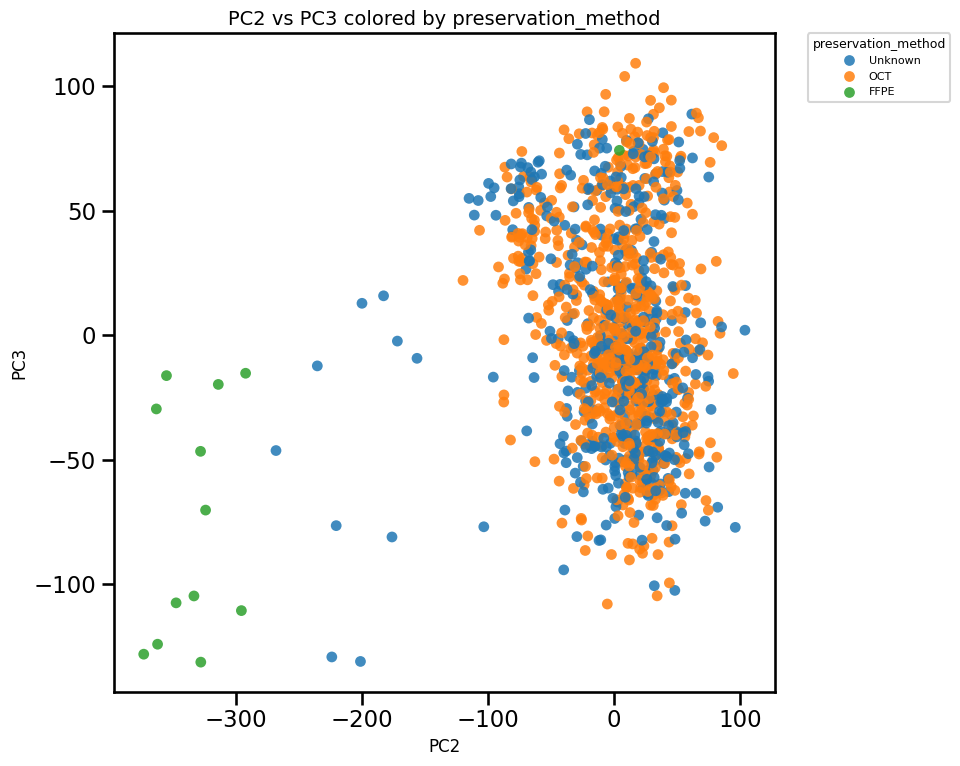

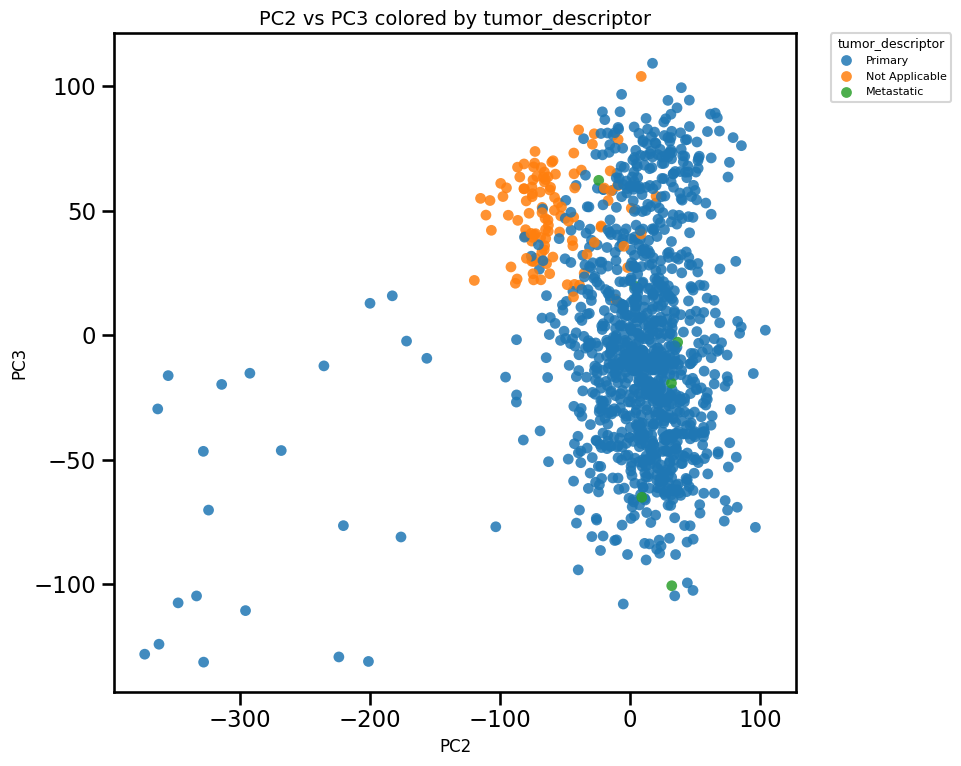

In [12]:
plot_pca_categorical(pca_with_biospecimen,x='PC2',y='PC3', hue_col="sample_type")
plot_pca_categorical(pca_with_biospecimen,x='PC2',y='PC3', hue_col="preservation_method")
plot_pca_categorical(pca_with_biospecimen,x='PC2',y='PC3', hue_col="tumor_descriptor")

## PC1 v/s PC2 across biospecimen continuous metrics
### 1. Days to collection (processing latency)
### 2. RNA concentration
### 3. Aliquot quantity (mg)


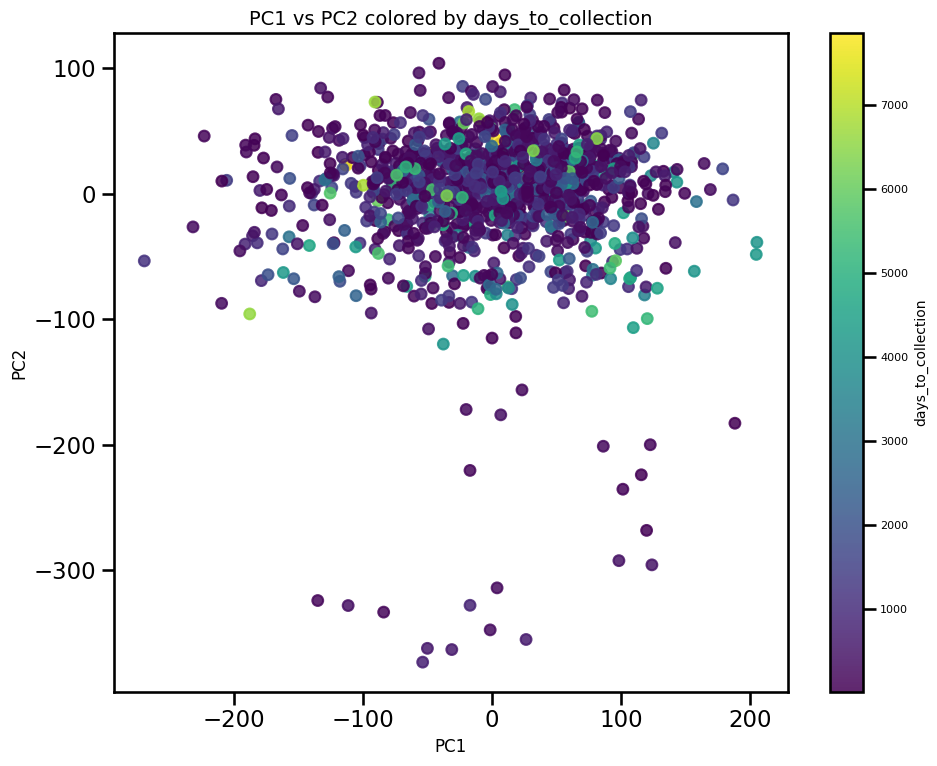

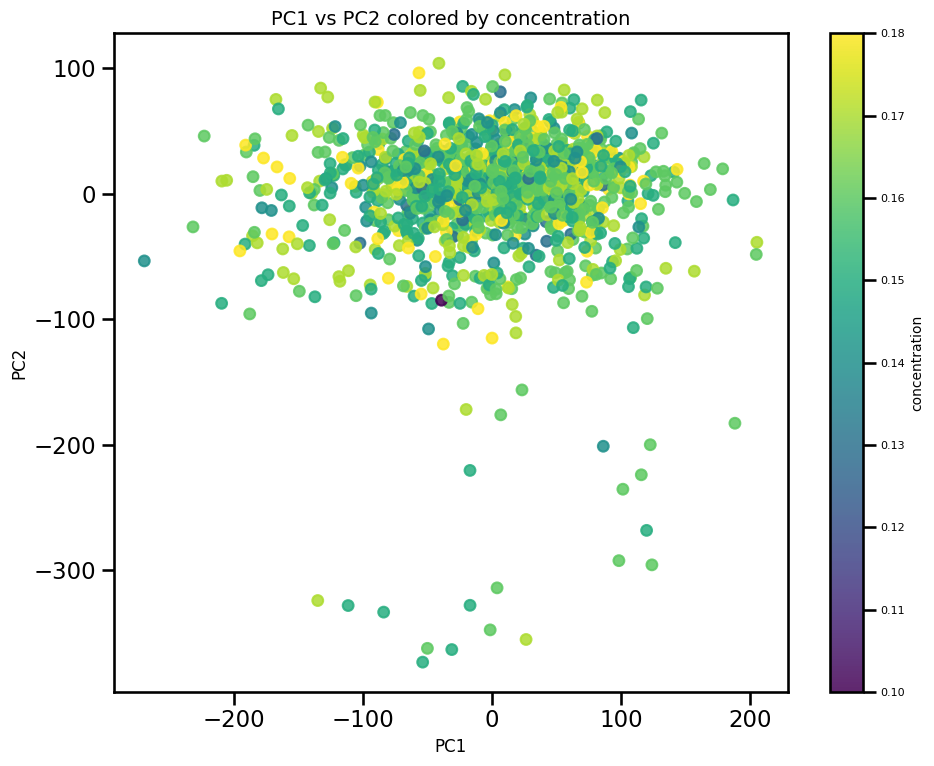

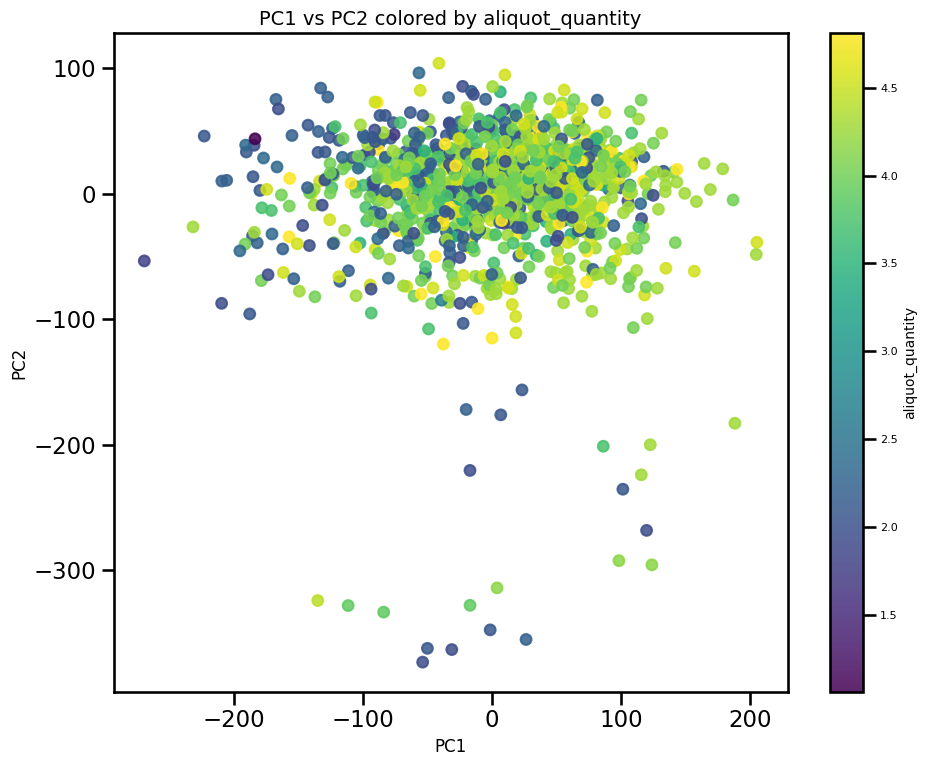

In [13]:
plot_pca_continuous(pca_with_biospecimen, color_col="days_to_collection")
plot_pca_continuous(pca_with_biospecimen, color_col="concentration")
plot_pca_continuous(pca_with_biospecimen, color_col="aliquot_quantity")                   

## PC2 v/s PC3 across biospecimen continuous metrics
### 1. Days to collection (processing latency)
### 2. RNA concentration
### 3. Aliquot quantity (mg)


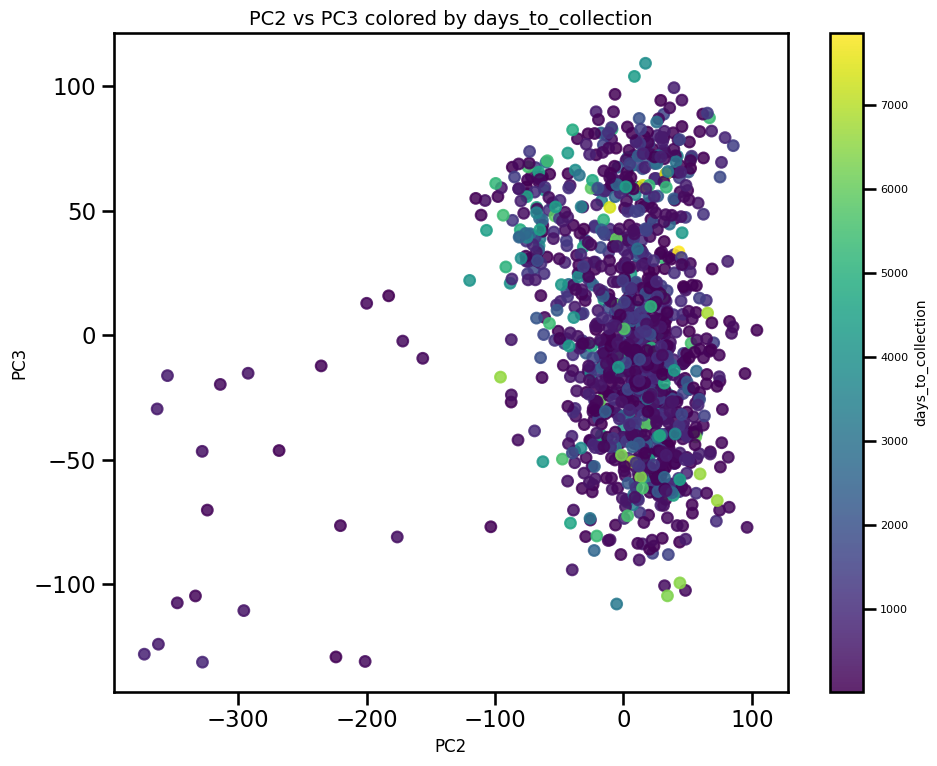

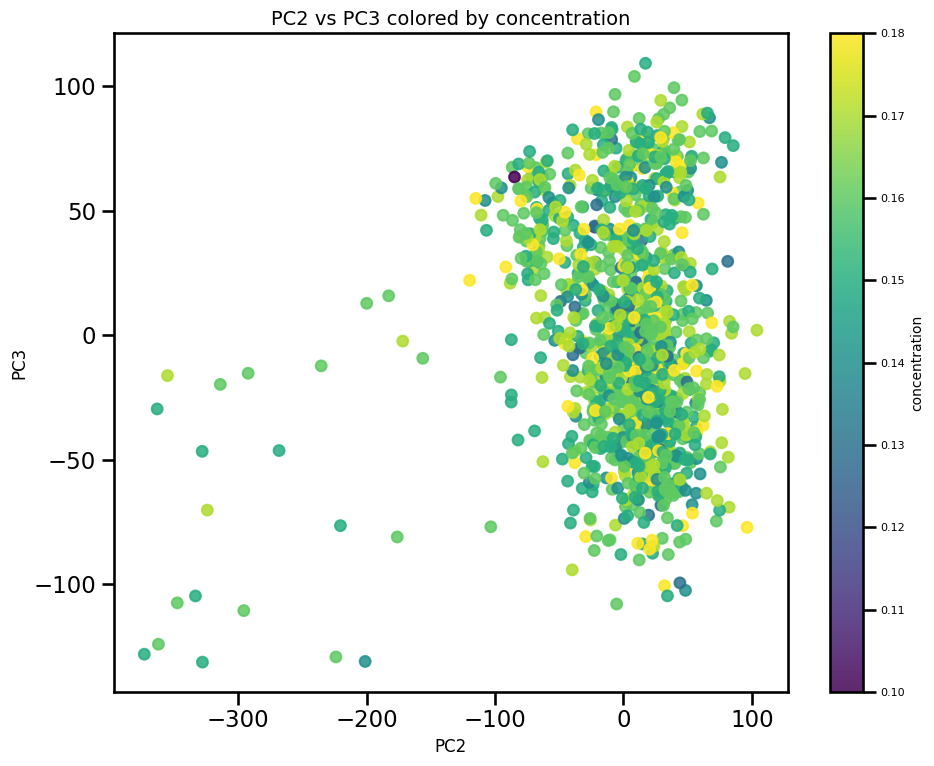

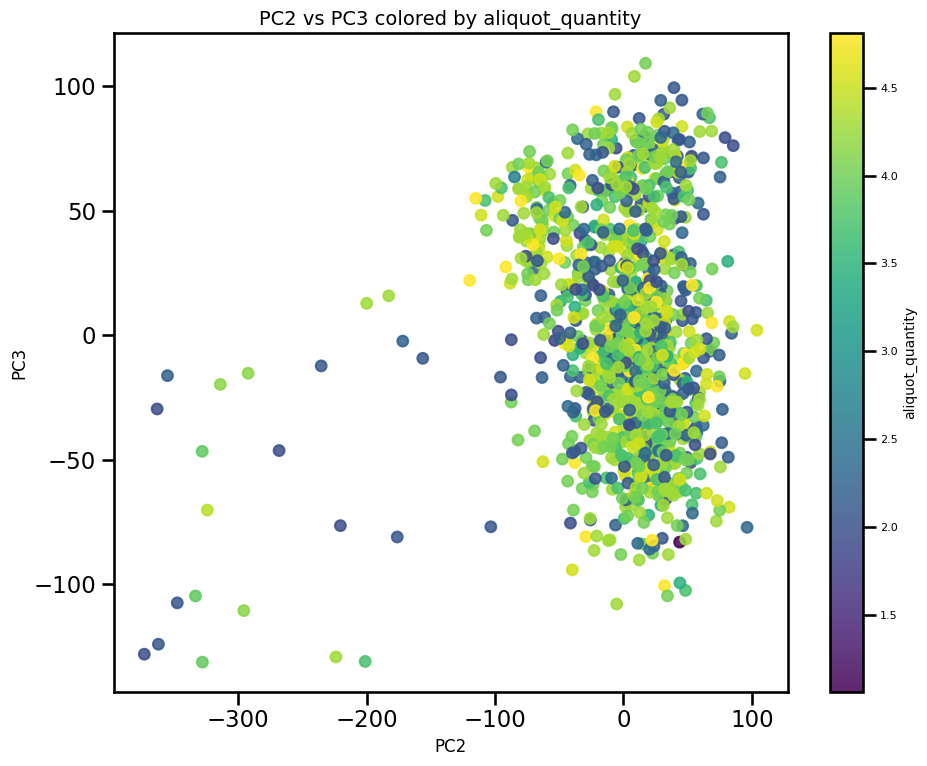

In [14]:
plot_pca_continuous(pca_with_biospecimen,x='PC2',y='PC3', color_col="days_to_collection")
plot_pca_continuous(pca_with_biospecimen,x='PC2',y='PC3', color_col="concentration")
plot_pca_continuous(pca_with_biospecimen,x='PC2',y='PC3', color_col="aliquot_quantity")                   

## Persist PCA scores for downstream notebooks


In [15]:
pca_output_path = PROCESSED_DATA_DIR / "tcga_brca_pca_scores.tsv.gz"
pca_df.to_csv(pca_output_path, sep="	", compression="gzip")
pca_output_path

PosixPath('/Users/lennonmccartney/Desktop/tcga-brca-multiomics-subtyping/data/processed/tcga_brca_pca_scores.tsv.gz')